In [1]:
import copy
import sys
import numpy as np
import time
from modules.module import Module

from modules import Sequential as Sequential_np
from modules import SoftMax    as SoftMax_np
from modules import Linear     as Linear_np

import matplotlib.pyplot as plt

import data_io, model_io
import model_io_mx

# mxnet:
import mxnet as mx
from mxnet import ndarray as nd

from mxmodules import Convolution
from mxmodules import SumPool
from mxmodules import Sequential
from mxmodules import SoftMax
from mxmodules import Linear
from mxmodules import Rect
from mxmodules import Flatten

In [2]:
Xtrain = data_io.read('../data/MNIST/train_images.npy')
Ytrain = data_io.read('../data/MNIST/train_labels.npy')

Xtest = data_io.read('../data/MNIST/test_images.npy')
Ytest = data_io.read('../data/MNIST/test_labels.npy')

#transfer the pixel values from [0 255] to [-1 1]
Xtrain = Xtrain / 127.5 -1
Xtest = Xtest / 127.5 -1

#transform numeric class labels to indicator vectors.
I = Ytrain[:,0].astype(int)
Ytrain = np.zeros([Xtrain.shape[0],np.unique(Ytrain).size])
Ytrain[np.arange(Ytrain.shape[0]),I] = 1

I = Ytest[:,0].astype(int)
Ytest = np.zeros([Xtest.shape[0],np.unique(Ytest).size])
Ytest[np.arange(Ytest.shape[0]),I] = 1

loading np-formatted data from ../data/MNIST/train_images.npy
loading np-formatted data from ../data/MNIST/train_labels.npy
loading np-formatted data from ../data/MNIST/test_images.npy
loading np-formatted data from ../data/MNIST/test_labels.npy


### Model and Context Definition

In [3]:
# ctx = mx.cpu()
ctx = mx.gpu(0)

#model a network according to LeNet-5 architecture
lenet = Sequential([
                Convolution(filtersize=(5,5,1,10),stride = (1,1), ctx=ctx),\
                Rect(),\
                SumPool(pool=(2,2),stride=(2,2), ctx=ctx),\
                Convolution(filtersize=(5,5,10,25),stride = (1,1), ctx=ctx),\
                Rect(),\
                SumPool(pool=(2,2),stride=(2,2), ctx=ctx),\
                Convolution(filtersize=(4,4,25,100),stride = (1,1), ctx=ctx),\
                Rect(),\
                SumPool(pool=(2,2),stride=(2,2), ctx=ctx),\
                Convolution(filtersize=(1,1,100,10),stride = (1,1), ctx=ctx),\
                Flatten(),\
                SoftMax()
            ])

In [4]:
# pad and reshape reshape convnet input and create mxnet ndarray:
Xtrain = Xtrain.reshape(-1, 28, 28,1)
Xtrain = np.pad(Xtrain,((0,0),(2,2),(2,2),(0,0)), 'constant', constant_values = (-1.,))
Xtrain_mx = nd.array(Xtrain, ctx=ctx)
Ytrain_mx = nd.array(Ytrain, ctx=ctx)

Xtest = Xtest.reshape(-1, 28, 28, 1)# [:1000] # TODO: attention: test set clipped
Xtest = np.pad(Xtest,((0,0),(2,2),(2,2),(0,0)), 'constant', constant_values = (-1.,))
Xtest_mx  = nd.array(Xtest,  ctx=ctx)
Ytest_mx  = nd.array(Ytest,  ctx=ctx)

### Training

In [5]:
#train the network.

strt = time.time()

#train the network.
lenet.train(   X=Xtrain_mx,\
                Y=Ytrain_mx,\
                Xval=Xtest_mx,\
                Yval=Ytest_mx,\
                iters=10**1,\
                lrate=0.001,\
                status=500,\
                batchsize=256)

stp = time.time()

print('Trained LeNet network in {}s'.format(stp - strt))

Setting network parameters to best encountered network state with 0.0% accuracy and a loss of 9223372036854775807 from iteration 0.
Trained LeNet network in 5.03852701187s


In [6]:
# model_io_mx.write(lenet, 'lenet')

In [10]:
# lenet_now_trained = lenet
lenet = model_io_mx.read('lenet')

loading pickled model from lenet_selbertrain


### LRP Heatmapping

In [11]:
num_images = 25
num_images_to_show = 5

target = 1
init_rel = ((nd.arange(10, ctx=ctx) == target) * 1.0).reshape((1, 10))
init_rel = nd.broadcast_to(init_rel, (num_images, 10))

input_batch = Xtrain_mx[0:num_images]

# forward pass and lrp calculation
strt        = time.time()
predictions = lenet.forward(input_batch)
relevance   = lenet.lrp(init_rel)

relevance.wait_to_read()

stp = time.time()

print('Calculated prediction and LRP scores for {} images in {}'.format(input_batch.shape[0], stp-strt))

Calculated prediction and LRP scores for 25 images in 1.47194886208


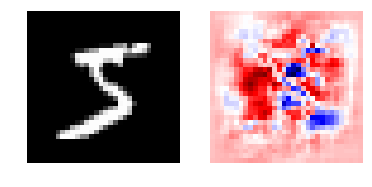

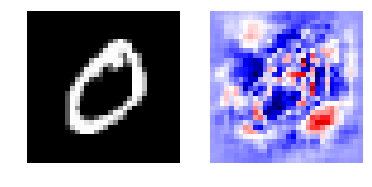

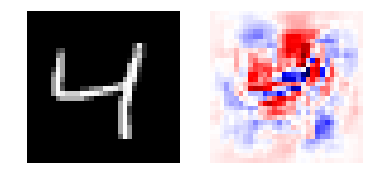

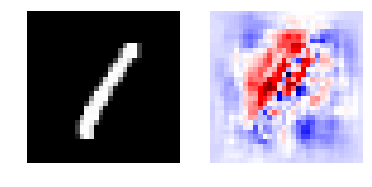

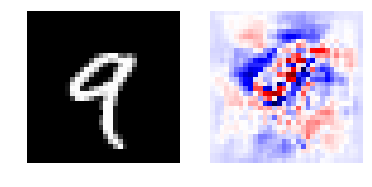

In [12]:
for i in range(num_images_to_show):

    # presentation
    plt.subplot(1,2,1)
    plt.imshow(Xtrain_mx[i].asnumpy().reshape(32, 32), cmap='gray')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(relevance[i].asnumpy().reshape(32, 32), cmap='seismic')
    plt.axis('off')
    plt.show()